# L6: Epidemics

In [403]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [404]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

from scipy.linalg import expm
from scipy import integrate

from IPython.display import display, Math

In [406]:
def get_filename(filename: str, lecture_id: int = 1, file_extension: str = '.png') -> str:
    return f"L{lecture_id}_{filename}{file_extension}"

outdir = '../figures/'
lecture_id = 6

In [407]:
fs = 20
color = 'salmon'

In [408]:
def dec_to_bin(x: int, N: int)-> str:
    # int(bin(x)[2:]
    return bin(x)[2:].zfill(N) # 0-pad on the left

def get_avg_d_from_pN(p: float, N: int) -> float:
    '''
    E[d] = 2L/N
    E[L] = p L_max
    --> E[d] = 2p L_max/N
    '''
    L_max = N * (N - 1) / 2
    d_avg = 2 * p * L_max / N
    return d_avg

def get_graph_from_Q(Q: np.ndarray,states: list, keep_selfloop: bool = False) -> nx.MultiDiGraph():
    G = nx.MultiDiGraph()
    assert Q.shape[0] == len(states)
    for start_idx, node_start in enumerate(states):
        for end_idx, node_end in enumerate(states):
            value = Q[start_idx][end_idx]
            if value != 0:
                G.add_edge(node_start,node_end, weight=value)

    if keep_selfloop == False:
        G.remove_edges_from(nx.selfloop_edges(G))
    return G

def get_P(Q:np.ndarray,t: float) -> np.ndarray:
    '''
    Get P(t) = exp(Qt)
    '''
    return expm(Q * t)


In [409]:
'''
------------------------------------------
            SETTINGS
------------------------------------------
'''
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = 'PT Sans'
# plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 12

ms = 100 # marker size
fs = 20 # fontsize
dpi = 100
BLUE = "#2a475e"

# 0. Classical compartmental model
The standard SIS compartmental model has these equations:

$
\frac{d S(t)}{dt}  = -\beta \, I(t) \, S(t) + \delta \,I
$

$
\frac{d I(t)}{dt}  =   \beta \, I(t) \, S(t)-\delta \, I(t)
$


We can see how to solve it numerically and plot the evolution of the system in terms of the observable quantity:
$
I(t)
$

In [410]:
def dSIS_homogeneous_meanfield(X, t, beta: float, delta: float, n_over_N: float = 1.0):
    S, I = X
    dSdt = delta * I - beta * n_over_N * S * I
    dIdt = -dSdt
    dX = np.array([dSdt,dIdt])
    return dX

In [470]:
delta = 1.
beta = 0.1
tau = beta / delta
print(f"tau = {tau}")

tau = 0.1


Beside the epidemic parameters, we need to specify:
- `d_avg`: how many individuals are influencing an individual, on average
- `N`: number of individuals
- `dynp_pINI`: fraction of initially infected nodes (initial condition)

In [471]:
d_avg = 1.
N = 100
dynp_pINI = 0.4

print(f"d_avg/N = {d_avg/(N-1):.2f}")

d_avg/N = 0.01


#### Steady-state
If $\tau\leq1$:
- $\pi_0=1$, trivial steady-state (all susceptible)

If $\tau>1$:
- $\pi_0=\frac{\delta}{\beta}=\frac{1}{\tau}$
- $\pi_1=\frac{\beta-\delta}{\delta} = \frac{\tau-1}{\tau}$

In [472]:
def get_compartmentSIS_pi1(beta: float, delta: float):
    tau = beta/delta
    if tau <=1:
        return 0
    else:
        return (tau-1) / tau

In [473]:
pi_1 = get_compartmentSIS_pi1(beta,delta)
print(f"Fraction of infected individuals (compartment SIS theory):\n{pi_1:.3f}")

Fraction of infected individuals (compartment SIS theory):
0.000


**Spoiler alert**. 
We expect the approximated steady-state to be:

$v_\infty = 1 - \frac{1}{\tau d}$

(You can check what this is referring to...)

In [474]:
v_infty = max(1 - 1/(tau * d_avg),0)
print(f"Fraction of infected individuals (NIMFA approximation):\n{v_infty:.3f}")

Fraction of infected individuals (NIMFA approximation):
0.000


### Running the dynamics
Using numerical integration of the differential equations with `integrate.odeint`

In [475]:
tmin = 0
tmax = 1e3
tcount = 10000
times = np.linspace(tmin, tmax, tcount)


In [476]:
I0 = dynp_pINI * N
S0 = N - I0
X0 = np.array([S0,I0])
times = np.linspace(tmin,tmax,tcount)
X = integrate.odeint(dSIS_homogeneous_meanfield, X0,times, 
                        args=( beta, delta, float(d_avg)/(N-1)))
S, I_HoMF = X.T
I_HoMF /= N

In [477]:
I_HoMF[:-5]

array([ 4.00000000e-01,  3.64198681e-01,  3.31715986e-01, ...,
       -3.38821337e-21, -3.38811513e-21, -3.38801689e-21])

In [478]:
outfile = None

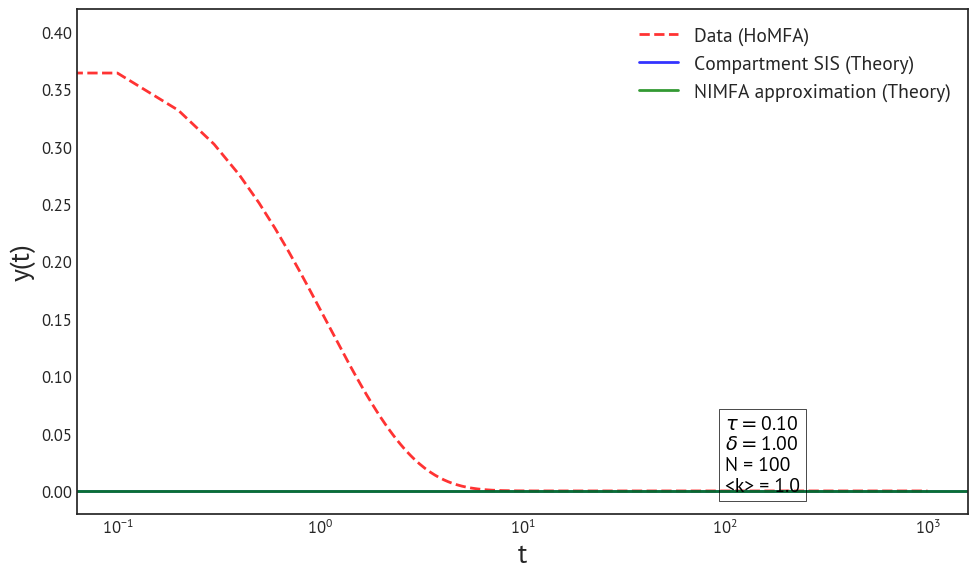

In [479]:
fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.plot(times,I_HoMF, ls='dashed',lw=2,c='red',alpha=0.8,label='Data (HoMFA)')
ax.axhline(pi_1, label='Compartment SIS (Theory)',lw=2,c='b',alpha=0.8)
ax.axhline(v_infty, label='NIMFA approximation (Theory)',lw=2,c='g',alpha=0.8)

ax.set_xlabel('t',fontsize=fs)
ax.set_ylabel(r'y(t)',fontsize=fs)
ax.set_xscale('log')
ax.legend()
msg = r'$\tau=$'+f"{tau:.2f}\n"
msg = msg + r'$\delta=$'+f"{delta:.2f}\n"
msg = msg + f"N = {N}\n"
msg = msg + f"<k> = {d_avg:.1f}"

ax.text(1e2,v_infty * 1.1, msg, color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        

You can play with the input parameters to see if you notice different behaviors...

### Track the steady-state fraction of infected individuals

For this, we need to vary the order parameters $\tau=\beta/\delta$ and see where the system converges to as a function of this order parameter

In [480]:
betas = np.linspace(1/d_avg * 0.1,1/d_avg*4,20)
Is = np.zeros((len(betas),tcount))
for bid,beta in enumerate(betas):

    X = integrate.odeint(dSIS_homogeneous_meanfield, X0,times, 
                        args=( beta, delta, float(d_avg)/N))
    S, I_HoMF = X.T
    I_HoMF /= N

    Is[bid,:] = I_HoMF


In [481]:
outfile = None

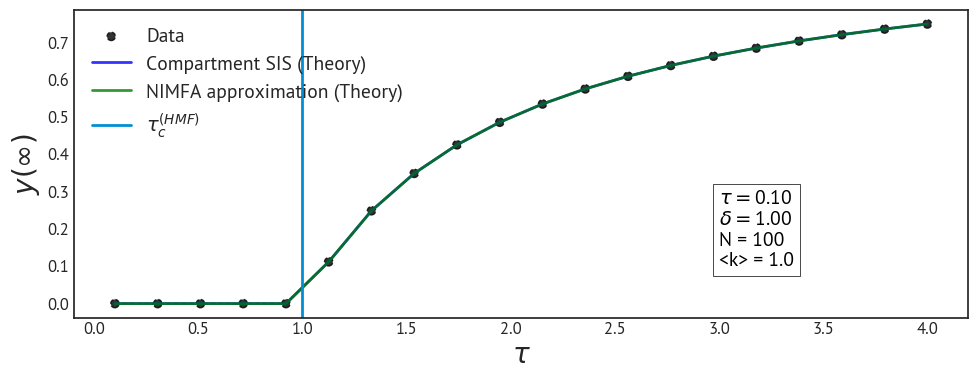

In [482]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))

y_theory_compartmentSIS = np.array([get_compartmentSIS_pi1(b,delta) for b in betas])
y_theory_NIMFA = np.array([max(1 - 1/((b/delta) * d_avg),0) for b in betas])
ax.scatter(betas,Is[:,-1], ls='--',lw=1,c='black',alpha=0.8, label='Data')
ax.plot(betas,Is[:,-1], ls='--',lw=1,c='black',alpha=0.8)
ax.plot(betas,y_theory_compartmentSIS, ls='-',lw=2,c='b',alpha=0.8, label='Compartment SIS (Theory)')
ax.plot(betas,y_theory_NIMFA, ls='-',lw=2,c='g',alpha=0.8, label='NIMFA approximation (Theory)')

ax.axvline(1/d_avg, lw=2,label=r'$\tau_c^{(HMF)}$')
ax.set_xlabel(r'$\tau$',fontsize=fs)
ax.set_ylabel(r'$y(\infty)$',fontsize=fs)

ax.legend()
msg = r'$\tau=$'+f"{tau:.2f}\n"
msg = msg + r'$\delta=$'+f"{delta:.2f}\n"
msg = msg + f"N = {N}\n"
msg = msg + f"<k> = {d_avg:.1f}"
# ax.set_title(msg)

# plt.text(1e4,0.5,f"tau_c = {tau_c1:.2f}")
ax.text(3/d_avg,0.1, msg, color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")

# 1. Exact $\epsilon$-SIS dynamics

Let's consider the _exact_ dynamics (for **small** $N$ only!) for a **random network** topology.

In [483]:
seed = 10
prng = np.random.RandomState(seed)

## 1.1 Set up the problem
Let's start by first creating the states, to familiarize ourselves with the binary notation:

$i=\sum_{k=1}^{N}x_{k}(i) \,2^{k-1}$



In [484]:
N = 4 # number of nodes, keep it small!
assert N <=10

states = [dec_to_bin(i,N) for i in range(2**N)] # in binary notation
states[:10]

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001']

## 1.2 Build $Q$

Let's now build $Q$, using:  
$
q_{ij} = \left\{ \begin{array}{ll}
                    \delta & j=i-2^{m-1}; m=1,\dots,N; x_m(i)=1 \;\;  \text{(infected nodes)} \\
                     \epsilon +\beta\sum_k a_{mk}\, x_k(i) & j=i+2^{m-1}; m=1,\dots,N; x_m(i)=0  \;\;\text{(susceptible nodes)}  \\
                      -\sum_{k\neq j} q_{kj} & i=j \;\;\text{(diagonal terms)}  \\
                      0 & \text{otherwise}
                \end{array}
        \right.
$

We need $A$, hence a graph. 

We use an ER model for generating the random graph.

In [485]:
p = 2 * np.log(N) / N

d_avg = get_avg_d_from_pN(p,N)

G = nx.erdos_renyi_graph(N, p, seed=seed)
A = nx.adjacency_matrix(G).toarray()

print(f"d_avg (theory)= {d_avg:.2f}")
print(f"d_avg (empirical) = {np.mean(list(dict(G.degree()).values())):.2f}")


d_avg (theory)= 2.08
d_avg (empirical) = 2.00


#### 1.2.1 Setup the main parameters

- $\epsilon$ (self-infection)
- $\beta$ (neighbors influence)
- $\delta$ (recovery)

Start fixing $\epsilon=0$, $\tau=\beta/\delta <1$ and then play with these values.

In [498]:
epsilon = 0.0
delta = 1.
beta = 0.1
tau = beta / delta
print(f"tau = {tau}")

eigenvalues, eigenvectors = np.linalg.eig(A) # needed to get tau_c1
tau_c1 = 1/np.max(eigenvalues)
print(f"1/lambda_1 = {tau_c1:.2f}")

tau = 0.1
1/lambda_1 = 0.46


### 1.2.2 Compute Q

In [499]:
Ns = np.arange(N)
V = len(states)
Q = np.zeros((V,V))
for i,si in enumerate(states):
    '''
    Transitions I --> S
    '''
    mask = np.array([si[m] for m in Ns]) == '1'
    infected_mid = Ns[mask]
    for m in infected_mid:
        sj = si 
        # sj[m] = '0' # switch 1 -> 0
        sj = si[:m] + '0' + si[m+1:]
        idx = states.index(sj)
        Q[i,idx] = delta
    '''
    Transitions S --> I
    '''
    mask = np.array([si[m] for m in Ns]) == '0'
    susceptible_mid = Ns[mask]
    for m in susceptible_mid:
        sj = si
        # sj[m] = '1' # switch 1 -> 0
        sj = si[:m] + '1' + si[m+1:]
        idx = states.index(sj)
        
        rate_A = sum([int(si[int(idx_n)]) for idx_n in np.where(A[m]==1)[0]])
        rate = epsilon + beta * rate_A
        Q[i,idx] = rate

'''
Diagonal entries
'''
for i in range(Q.shape[0]):
    rowSum = Q[i].sum() 
    Q[i,i] = - (rowSum - Q[i,i])


Check that the only "all-zero" transition is the trivial "all-health" state (absorbing)

In [500]:
np.where(np.sum(Q,axis=1) - np.diag(Q) == 0)[0]

array([0])

In [501]:
filename = 'SIS_exact_example'
if N <= 4:
    outfile = get_filename(filename,lecture_id=lecture_id)
else:
    outfile = None

### 1.2.3 Visualize $A$ and $Q$

Figure saved in ../figures/L6_SIS_exact_example.png


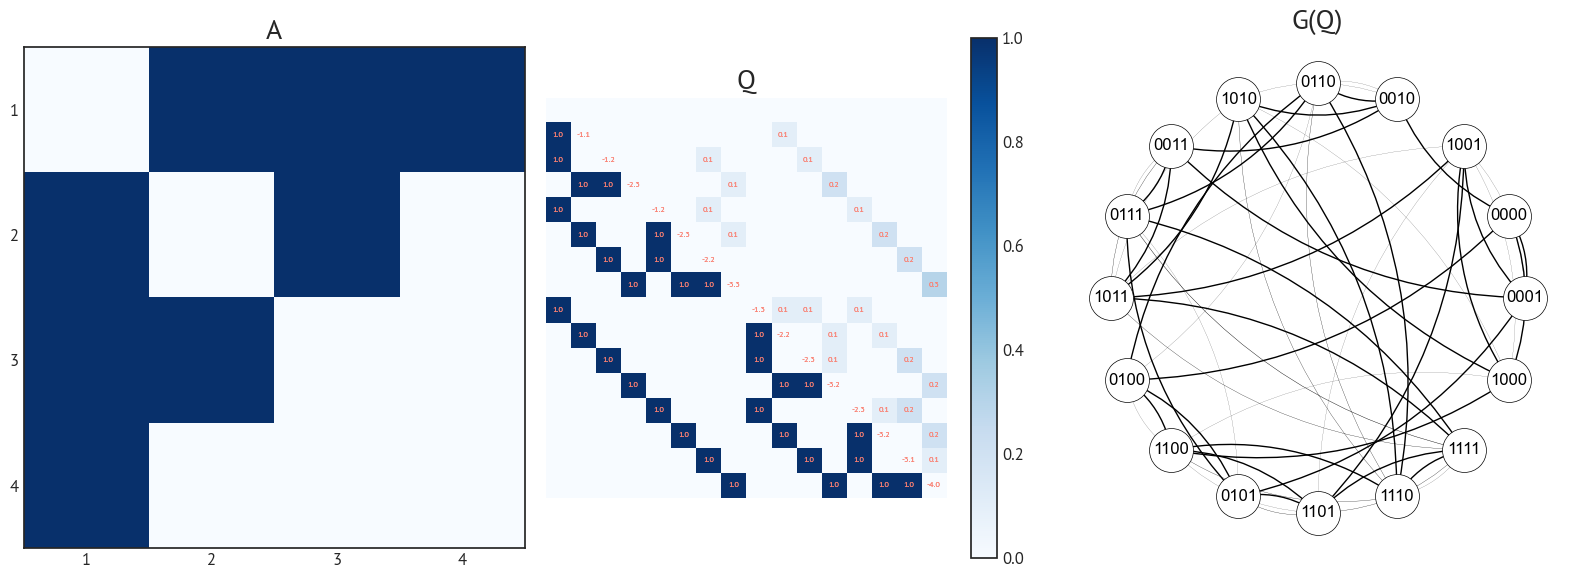

In [502]:
plt.figure(figsize=(16,6))


'''
Adjacency matrix of the network
'''
plt.subplot(1,3,1)
plt.imshow(A, vmax=1,vmin=0, cmap='Blues')
plt.title(f"A",fontsize=fs)
plt.xticks(np.arange(N),labels=np.arange(1,N+1))
plt.yticks(np.arange(N),labels=np.arange(1,N+1))
# plt.axis('off')
# plt.colorbar()

'''
Q
'''
plt.subplot(1,3,2)
plt.imshow(Q, vmax=1,vmin=0, cmap='Blues')

for (j,i),label in np.ndenumerate(Q):
    if label != 0:
        plt.text(i,j,f"{label:.1f}",ha='center',va='center', c=color, fontsize = 6)
        plt.text(i,j,f"{label:.1f}",ha='center',va='center', c=color, fontsize = 6)
plt.axis('off')
plt.colorbar()
plt.title(f"Q",fontsize=fs)

'''
Markov graph from Q
'''
plt.subplot(1,3,3)
ax = plt.gca()

G_Q = get_graph_from_Q(Q,states)

# pos = nx.spring_layout(G_Q, seed=10,iterations=1)
pos = nx.circular_layout(G_Q)

nx.draw_networkx_nodes(G_Q, pos, node_size=1000, edgecolors='black', node_color='white',ax=ax)
nx.draw_networkx_labels(G_Q, pos, font_size=12,ax=ax)

arc_rad = 0.2

w = [G_Q[nodes[0]][nodes[1]][0]['weight']for nodes in G_Q.edges]
edges = nx.draw_networkx_edges(G_Q, pos, ax=ax, connectionstyle=f'arc3, rad = {arc_rad}', edge_cmap=cm.Blues, width=w)

pc = mpl.collections.PatchCollection(edges, cmap=cm.Blues)

# ax = plt.gca()
ax.set_axis_off()
# plt.colorbar(pc, ax=ax)
plt.title(f"G(Q)",fontsize=fs)

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

## 1.3 Run the dynamics

We need to choose an observable quantity to track, and interesting and representative quantity for the dynamics.

One such quantity is the expected value of the number of infected individuals:

- $y(t) = \frac{1}{N} \sum_{k} E[X_{k}(t)=1]$

This can be computed by taking:

- $y(t) = \frac{1}{N}\sum_{j =1}^{2^N} f(s_j)\, P(s_j(t))$,

  where $f(s_j)=\sum_{m=1}^N x_m(j)$, i.e. the total number of infected individuals in a state $s_j$.


#### Select initial state and assign all probability to it (as in a Diract-delta)

- $X(0) = x_0$
- $S(0) = \delta(X(0) - x_0)$

In [503]:
# x = prng.choice([0, 1], size=(N,))
x = prng.choice(states, size=(1,))[0]
print(f"Initial state = {x}")

Initial state = 0110


In [504]:
S_0 = np.zeros(V)
idx0 = states.index(x)
S_0[idx0] = 1. # all probability mass is placed in the initial state


Let's now build the matrices to compute $y(t)$.  

- $S(t)^T = S_0^T\, e^{Qt}$

In [505]:
P = get_P(Q, t = 1)
S_t = np.dot(S_0, P)
assert np.allclose(S_t.sum(),1)

In [506]:
def get_y_t(S_t: np.array, N: int)-> float:
    Ns = np.arange(N)
    y_t = 0
    for i,pi in enumerate(S_t):
        n1 = np.sum(np.array([states[i][m-1] for m in Ns]) == '1') # computes the number of '1' in a state
        y_t +=  n1 * pi # weighted by the probability of that state
    return y_t

#### Run the dynamics for various time steps

In [507]:
time_steps = [0.01,0.05,0.1,0.5,1.0,2.0,5.0,10.,1e2,1e3,1e4, 1e5, 1e6]
time_steps.sort()
T = len(time_steps)+1 # number of timesteps to simulate

R = 100 # number of samples (different initial states)
y_t = np.zeros((R,T))
for r in np.arange(R):
    # Set initial state
    x = prng.choice(states, size=(1,))[0]
    S_0 = np.zeros(V)
    idx0 = states.index(x)
    S_0[idx0] = 1. # all probability mass is placed in the initial state
    # print(f"Starting state distribution = {S_0}")
    # print(f"Starting state = {x}")
    '''
    Compute y(t) as a function of time
    '''
    y_t[r,0] = get_y_t(S_0,N) / N
    for i, t in enumerate(time_steps):
        
        P = get_P(Q, t = t)
        S_t = np.dot(S_0, P)
    
        y_t[r,i+1] = get_y_t(S_t,N) / N

In [508]:
filename = f'SIS_exact_y_infty_e{epsilon:.2}_tau{tau:.2f}'
outfile = get_filename(filename,lecture_id=lecture_id)

# outfile = None

Figure saved in ../figures/L6_SIS_exact_y_infty_e0.0_tau0.10.png


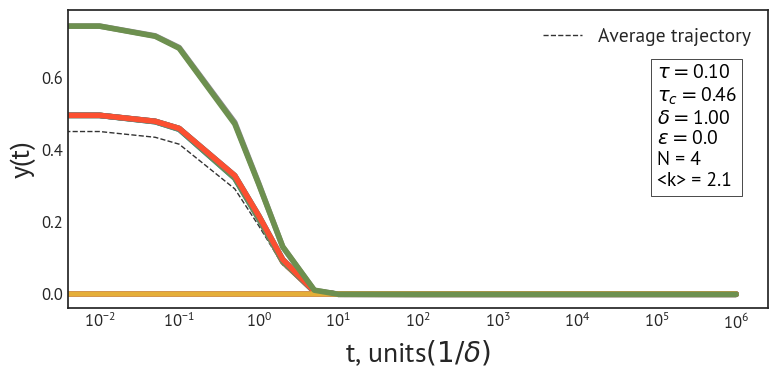

In [509]:
fig, ax = plt.subplots(1,1,figsize=(8, 4))
xs = [0] + list(time_steps)
xs = [x/ (1/delta) for x in xs]
ys = np.mean(y_t,axis=0)
ax.plot(xs,ys, ls='--',lw=1,c='black',alpha=0.8,label='Average trajectory')


for i in range(10):
    ax.plot(xs,y_t[i])

ax.set_xlabel('t, units'+ r'$ (1/\delta)$',fontsize=fs)
ax.set_ylabel(r'y(t)',fontsize=fs)
ax.set_xscale('log')
ax.legend()
msg = r'$\tau=$'+f"{tau:.2f}\n"
msg = msg + r'$\tau_c=$'+f"{tau_c1:.2f}\n"
msg = msg + r'$\delta=$'+f"{delta:.2f}\n"
msg = msg + r'$\epsilon=$'+f"{epsilon:.1f}\n"
msg = msg + f"N = {N}\n"
msg = msg + f"<k> = {d_avg:.1f}"
# ax.set_title(msg)

# plt.text(1e4,0.5,f"tau_c = {tau_c1:.2f}")
ax.text(1e5,0.3, msg, color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        

#### Q: how do we change parameters to see a **metastable** state?

Play with them and try!

# 2. NIMFA simulation
We can run this approximation by using the ODE:

$\frac{d v_{i}(t)}{dt} = -\delta \, v_{i}(t)  + (1-v_{i}(t)) [\beta \sum_{k}a_{ik}v_{k}(t)  +\epsilon] $

and using numerical integration with `scipy.integrate.ode`

In [510]:
from scipy import integrate

In [511]:
def dSIS_NIMFA(Y, t, neighs: dict, beta: float = 1., delta: float = 0., epsilon: float = 0.):
    N = len(neighs)
    dY = np.zeros(N)
    for i in np.arange(N):
        dY[i] = sum(beta * (1-Y[i]) * Y[nbr] for nbr in neighs[i]) + (1-Y[i]) * epsilon - delta * Y[i]

    return dY

In [513]:
tmin = 0
tmax = 1e3
tcount = 100000
times = np.linspace(tmin, tmax, tcount)

Y0 = dynp_pINI * np.ones(N)

Y = integrate.odeint(dSIS_NIMFA, Y0, times,  
                                args =(neighs, beta, delta, epsilon))
# Is = sum(Y.T) / N
Is = Y.T 
Is = np.mean(Is,axis=0)
Is[-5:]

array([-4.59089716e-19, -4.59088501e-19, -4.59087287e-19, -4.59086072e-19,
       -4.59084858e-19])

In [514]:
outfile = None

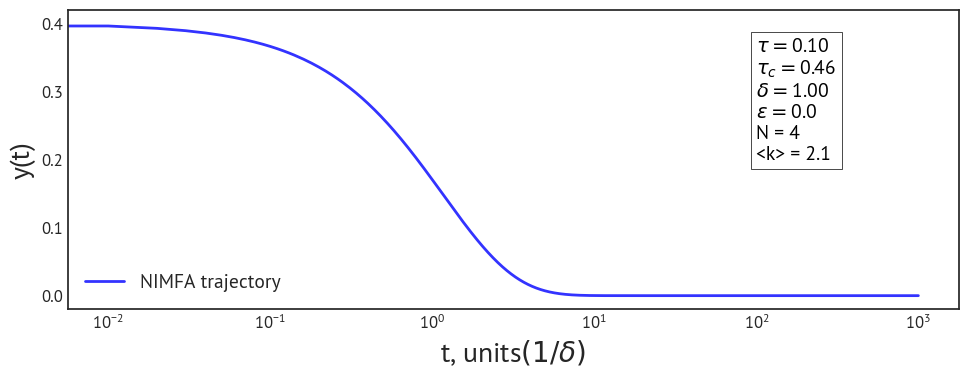

In [523]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))

ax.plot(times,Is, ls='-',lw=2,c='blue',alpha=0.8,label='NIMFA trajectory')

ax.set_xlabel('t, units'+ r'$ (1/\delta)$',fontsize=fs)
ax.set_ylabel(r'y(t)',fontsize=fs)
ax.set_xscale('log')
ax.legend()
msg = r'$\tau=$'+f"{tau:.2f}\n"
msg = msg + r'$\tau_c=$'+f"{tau_c1:.2f}\n"
msg = msg + r'$\delta=$'+f"{delta:.2f}\n"
msg = msg + r'$\epsilon=$'+f"{epsilon:.1f}\n"
msg = msg + f"N = {N}\n"
msg = msg + f"<k> = {d_avg:.1f}"
# ax.set_title(msg)

# plt.text(1e4,0.5,f"tau_c = {tau_c1:.2f}")
ax.text(1e2,0.2, msg, color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        

Try with larger N!

## 3.1 Vary $\tau$ and track steady-state
We could check how is the steady-state of the expected fraction of infected nodes changing with $\tau=\beta/\delta$ 

We can keep $\delta$ fixed and vary $\beta$

In [555]:
N = 100 # number of nodes, keep it small!
p = 2 * np.log(N) / N

d_avg = get_avg_d_from_pN(p,N)
G = nx.erdos_renyi_graph(N, p, seed=seed)
A = nx.adjacency_matrix(G).toarray()

degrees = A.sum(axis=1)
neighs = {i : np.where(A[i]>0)[0] for i in range(N)}

print(f"d_avg (theory)= {d_avg:.2f}")
print(f"d_avg (empirical) = {np.mean(list(dict(G.degree()).values())):.2f}")

eigenvalues, eigenvectors = np.linalg.eig(A) # needed to get tau_c1
tau_c1 = 1/np.max(eigenvalues)
print(f"1/lambda_1 = {tau_c1:.2f}")

d_avg (theory)= 9.12
d_avg (empirical) = 8.54
1/lambda_1 = 0.10


In [556]:
tmin = 0
tmax = 1e3
tcount = 100000
times = np.linspace(tmin, tmax, tcount)

dynp_pINI = 0.6
Y0 = dynp_pINI * np.ones(N)

betas = np.linspace(tau_c1 * 0.8,tau_c1*4,20)
Is = np.zeros((len(betas),tcount))
for bid,beta in enumerate(betas):
    # print(f"beta={beta:.2} | 1/lambda_1 = {tau_c1:.2f} vs tau={beta/delta:.2f}")
    Y0 = dynp_pINI * np.ones(N)
    Y = integrate.odeint(dSIS_NIMFA, Y0, times,  
                                    args =(neighs, beta, delta, epsilon))
    # Is = sum(Y.T) / N
    Is_tmp = Y.T 
    Is[bid,:] = np.mean(Is_tmp,axis=0)

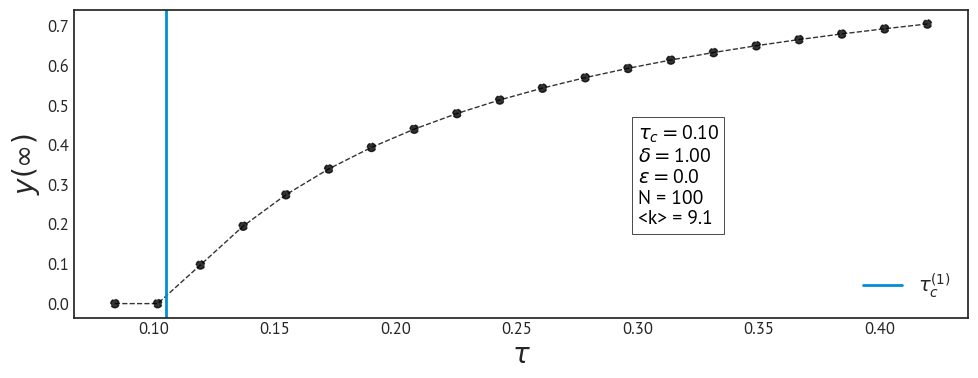

In [560]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))

ax.scatter(betas,Is[:,-1], ls='--',lw=1,c='black',alpha=0.8)
ax.plot(betas,Is[:,-1], ls='--',lw=1,c='black',alpha=0.8)

ax.axvline(tau_c1, lw=2,label=r'$\tau_c^{(1)}$')
ax.set_xlabel(r'$\tau$',fontsize=fs)
ax.set_ylabel(r'$y(\infty)$',fontsize=fs)

ax.legend()
msg = r'$\tau_c=$'+f"{tau_c1:.2f}\n"
msg = msg + r'$\delta=$'+f"{delta:.2f}\n"
msg = msg + r'$\epsilon=$'+f"{epsilon:.1f}\n"
msg = msg + f"N = {N}\n"
msg = msg + f"<k> = {d_avg:.1f}"
# ax.set_title(msg)

# plt.text(1e4,0.5,f"tau_c = {tau_c1:.2f}")
ax.text(0.3,0.2, msg, color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")

Check also what happens if you change the initial fraction of infected nodes

## 3.2 Compare with homogeneous approx (no network structure)
The only information needed is the average degree, i.e. average number of infected individuals that can infect a given sucseptible node

Set up network parameters

In [538]:
N = 100 # number of nodes, keep it small!
p = 2 * np.log(N) / N

d_avg = get_avg_d_from_pN(p,N)
G = nx.erdos_renyi_graph(N, p, seed=seed)
A = nx.adjacency_matrix(G).toarray()

degrees = A.sum(axis=1)
neighs = {i : np.where(A[i]>0)[0] for i in range(N)}

print(f"d_avg (theory)= {d_avg:.2f}")
print(f"d_avg (empirical) = {np.mean(list(dict(G.degree()).values())):.2f}")

eigenvalues, eigenvectors = np.linalg.eig(A) # needed to get tau_c1
tau_c1 = 1/np.max(eigenvalues)
print(f"1/lambda_1 = {tau_c1:.2f}")

d_avg (theory)= 9.12
d_avg (empirical) = 8.54
1/lambda_1 = 0.10


In [539]:
d_avg = np.mean(degrees)

Setup epidemic parameters

In [540]:
epsilon = 0.0
delta = 1.
beta = 1.
tau = beta / delta
print(f"tau = {tau}")

tau = 1.0


Computational parameters

In [541]:
tmin = 0
tmax = 1e3
tcount = 100000
times = np.linspace(tmin, tmax, tcount)


Run Homogeneous MF

In [542]:
dynp_pINI = 0.2

In [543]:
I0 = dynp_pINI * N
S0 = N - I0
X0 = np.array([S0,I0])
times = np.linspace(tmin,tmax,tcount)
X = integrate.odeint(dSIS_homogeneous_meanfield, X0,times, 
                        args=(float(d_avg)/N, tau, delta))
S, I_HoMF = X.T
I_HoMF /= N

Run NIMFA

In [544]:

Y0 = dynp_pINI * np.ones(N)

Y = integrate.odeint(dSIS_NIMFA, Y0, times,  
                                args =(neighs, beta, delta, epsilon))
# Is = sum(Y.T) / N
Is = Y.T 
Is = np.mean(Is,axis=0)
Is[-5:]

array([0.87120732, 0.87120732, 0.87120732, 0.87120732, 0.87120732])

Plot

In [545]:
outfile = None

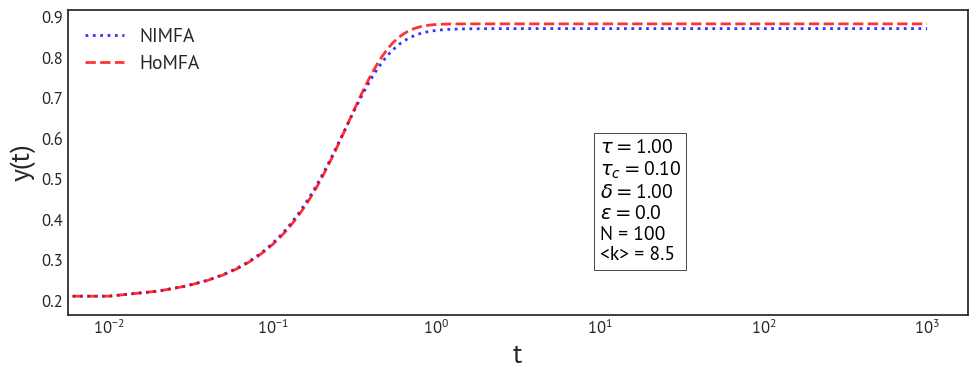

In [553]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))

ax.plot(times,Is, ls='dotted',lw=2,c='blue',alpha=0.8,label='NIMFA')
ax.plot(times,I_HoMF, ls='dashed',lw=2,c='red',alpha=0.8,label='HoMFA')

ax.set_xlabel('t',fontsize=fs)
ax.set_ylabel(r'y(t)',fontsize=fs)
ax.set_xscale('log')
ax.legend()
msg = r'$\tau=$'+f"{tau:.2f}\n"
msg = msg + r'$\tau_c=$'+f"{tau_c1:.2f}\n"
msg = msg + r'$\delta=$'+f"{delta:.2f}\n"
msg = msg + r'$\epsilon=$'+f"{epsilon:.1f}\n"
msg = msg + f"N = {N}\n"
msg = msg + f"<k> = {d_avg:.1f}"
# ax.set_title(msg)

# plt.text(1e4,0.5,f"tau_c = {tau_c1:.2f}")
ax.text(1e1,0.3, msg, color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        

How do you make results more different?